In [123]:
import pandas as pd
import requests
from io import StringIO
from data_science_hack_functions import *
from ucimlrepo import fetch_ucirepo 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate 

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve, KFold, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, make_scorer, log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import optuna

In [73]:
spambase = fetch_ucirepo(id=94) 

X = spambase.data.features 
y = spambase.data.targets 

# MODEL 1: BASED ON OVERALL PREDICTIVE ACCURACY

### EXPLORATION

In [74]:
summary_dataframe(X)


Summary Statistics:
╒════════════════════════════╤═════════════╤════════════════╤══════════════════╤═════════════╤═════════════════╤════════════╤═══════════════════╤════════════════════════╕
│ Column Name                │ Data Type   │   Total Values │   Missing Values │   Missing % │   Unique Values │   Unique % │ Constant Column   │ Cardinality Category   │
╞════════════════════════════╪═════════════╪════════════════╪══════════════════╪═════════════╪═════════════════╪════════════╪═══════════════════╪════════════════════════╡
│ word_freq_make             │ float64     │           4601 │                0 │           0 │             142 │       3.09 │ False             │ High                   │
├────────────────────────────┼─────────────┼────────────────┼──────────────────┼─────────────┼─────────────────┼────────────┼───────────────────┼────────────────────────┤
│ word_freq_address          │ float64     │           4601 │                0 │           0 │             171 │       3.72 

In [75]:
summary_dataframe(y)


Summary Statistics:
╒═══════════════╤═════════════╤════════════════╤══════════════════╤═════════════╤═════════════════╤════════════╤═══════════════════╤════════════════════════╕
│ Column Name   │ Data Type   │   Total Values │   Missing Values │   Missing % │   Unique Values │   Unique % │ Constant Column   │ Cardinality Category   │
╞═══════════════╪═════════════╪════════════════╪══════════════════╪═════════════╪═════════════════╪════════════╪═══════════════════╪════════════════════════╡
│ Class         │ int64       │           4601 │                0 │           0 │               2 │       0.04 │ False             │ Low                    │
╘═══════════════╧═════════════╧════════════════╧══════════════════╧═════════════╧═════════════════╧════════════╧═══════════════════╧════════════════════════╛

Descriptive Statistics (Numerical Data):
╒═══════╤═════════╤══════════╤══════════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════════╤════════════╤════════════════════╕
│       │   count 

In [76]:
summary_column(y, 'Class')


Analysis for Column: Class

Summary Statistics:
╒═══════════════════════╤═════════════════════╕
│ Metric                │ Value               │
╞═══════════════════════╪═════════════════════╡
│ Data Type             │ int64               │
├───────────────────────┼─────────────────────┤
│ Total Values          │ 4601                │
├───────────────────────┼─────────────────────┤
│ Non-Missing Values    │ 4601                │
├───────────────────────┼─────────────────────┤
│ Missing Values        │ 0                   │
├───────────────────────┼─────────────────────┤
│ Missing %             │ 0.0                 │
├───────────────────────┼─────────────────────┤
│ Unique Values         │ 2                   │
├───────────────────────┼─────────────────────┤
│ Variance              │ 0.23882539712541623 │
├───────────────────────┼─────────────────────┤
│ Skewness              │ 0.4336699490231419  │
├───────────────────────┼─────────────────────┤
│ Kurtosis              │ -1.8119303753

### FEATURE ENGINEERING

In [77]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [122]:
y.value_counts()

Class
0        2788
1        1813
Name: count, dtype: int64

THERE IS MILD CLASS IMBALANCE, BUT IM AVOIDING SMOTE FOR THIS PROCESS

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3680, 57), (921, 57), (3680, 1), (921, 1))

### MODEL SELECTION USING NESTED CV

In [ ]:
param_grids = {
    'logistic': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']  
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'knn': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'mlp': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'solver': ['adam'],
        'learning_rate': ['constant', 'adaptive']
    },
    'gboost': {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
}


In [63]:
# Model constructors
model_dict = {
    'logistic': LogisticRegression(),
    'svm': SVC(probability=True),
    'knn': KNeighborsClassifier(),
    'random_forest': RandomForestClassifier(),
    'mlp': MLPClassifier(max_iter=500),
    'gboost': GradientBoostingClassifier()
}

In [141]:
def run_nested_cv(X, y, model_dict, param_grids, scoring_list=['accuracy'], outer_splits=3, inner_splits=3):
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)

    y = np.ravel(y)

    results = {}
    summary_rows = []

    for model_name, model in model_dict.items():
        print(f"\n{'='*60}")
        print(f" Running Nested CV for: {model_name}")
        print(f"{'='*60}")
        
        needs_scaling = model_name not in ['random_forest', 'gboost']
        steps = [('scaler', StandardScaler())] if needs_scaling else []
        steps.append(('clf', model))
        pipe = Pipeline(steps)

        param_grid = {f'clf__{k}': v for k, v in param_grids[model_name].items()}
        results[model_name] = {}

        for scoring in scoring_list:
            print(f"\n→ Scoring Metric: {scoring if isinstance(scoring, str) else 'Custom Scorer'}")
            grid = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring=scoring, n_jobs=-1)
            nested_scores = cross_val_score(grid, X, y, cv=outer_cv, scoring=scoring, n_jobs=-1)

            grid.fit(X, y)
            best_params = grid.best_params_

            mean_score = nested_scores.mean()
            std_score = nested_scores.std()

            print(tabulate([[f"{mean_score:.4f}", f"{std_score:.4f}"]], headers=["Mean Score", "Std Dev"], tablefmt="pretty"))
            print("Best Hyperparameters:")
            for k, v in best_params.items():
                print(f"   - {k}: {v}")

            results[model_name][scoring] = {
                'score_mean': mean_score,
                'score_std': std_score,
                'best_params': best_params
            }

            summary_rows.append({
                'Model': model_name,
                'Metric': scoring,
                'Mean Score': mean_score,
                'Std Dev': std_score
            })

    # Summary Table
    print(f"\n{'='*60}")
    print(" Final Model Performance Summary")
    print(f"{'='*60}")
    summary_df = pd.DataFrame(summary_rows)
    print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False))

    print("\n Generating Model Comparison Visuals...")

    plot_df = summary_df.pivot(index='Model', columns='Metric', values='Mean Score')

    # Define standard 0–1 metrics
    bounded_metrics = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision', 'balanced_accuracy'}
    all_metrics = set(plot_df.columns)

    bounded = sorted(list(all_metrics.intersection(bounded_metrics)))
    unbounded = sorted(list(all_metrics.difference(bounded_metrics)))

    sns.set(style="whitegrid")
    palette = sns.color_palette("Set2", n_colors=len(plot_df))

    # --- Plot Bounded Metrics Together ---
    if bounded:
        print(" Plotting bounded [0–1] metrics...")
        bounded_df = plot_df[bounded]
        ax = bounded_df.plot(kind='bar', figsize=(10, 6), color=palette, rot=0)
        ax.set_title("Model Comparison (Bounded Metrics 0–1)")
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)
        ax.set_xlabel("Model")
        ax.grid(axis='y')
        ax.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    # --- Plot Unbounded Metrics Separately ---
    if unbounded:
        print(" Plotting unbounded/other-range metrics...")
        num_metrics = len(unbounded)
        fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(6 * num_metrics, 6), sharey=True)

        if num_metrics == 1:
            axes = [axes]

        for ax, metric in zip(axes, unbounded):
            metric_data = plot_df[metric].sort_values()
            metric_data.plot(kind='barh', ax=ax, color=palette)
            ax.set_title(f"Model Comparison ({metric})")
            ax.set_xlabel("Mean Score")
            ax.set_ylabel("Model")
            ax.grid(axis='x')

        plt.tight_layout()
        plt.show()


 Running Nested CV for: logistic

→ Scoring Metric: ACCURACY
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|   0.9226   | 0.0067  |
+------------+---------+
Best Hyperparameters:
   - clf__C: 100
   - clf__penalty: l2
   - clf__solver: liblinear

→ Scoring Metric: ROC_AUC
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|   0.9714   | 0.0010  |
+------------+---------+
Best Hyperparameters:
   - clf__C: 10
   - clf__penalty: l1
   - clf__solver: liblinear

 Running Nested CV for: svm

→ Scoring Metric: ACCURACY
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|   0.9302   | 0.0029  |
+------------+---------+
Best Hyperparameters:
   - clf__C: 10
   - clf__gamma: scale
   - clf__kernel: rbf

→ Scoring Metric: ROC_AUC
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|   0.9775   | 0.0011  |
+------------+---------+
Best Hyperparameters:
   - clf__C: 10
   - clf__gamma: scale
   - c

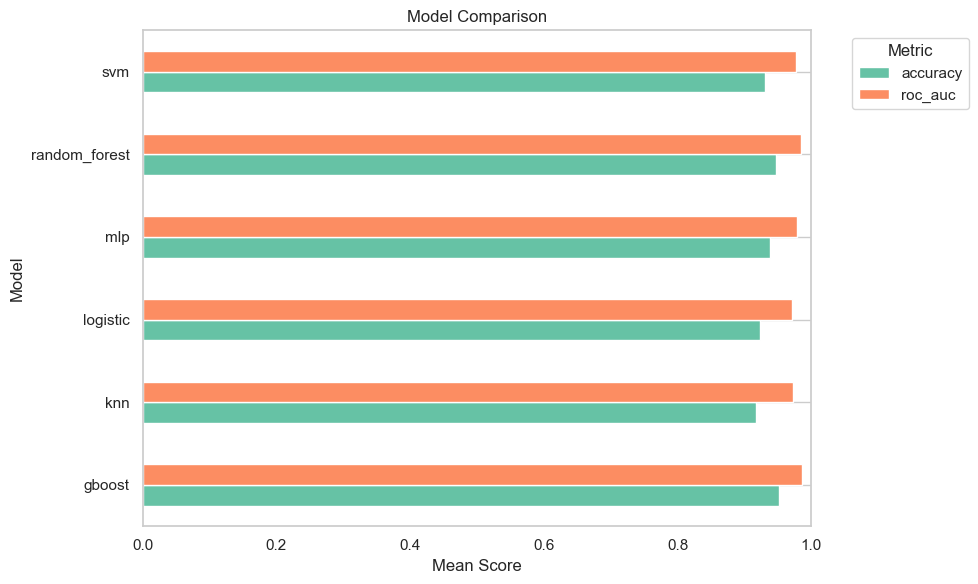

{'logistic': {'accuracy': {'score_mean': 0.9226254616317305,
   'score_std': 0.006655696838812152,
   'best_params': {'clf__C': 100,
    'clf__penalty': 'l2',
    'clf__solver': 'liblinear'}},
  'roc_auc': {'score_mean': 0.9714425150199709,
   'score_std': 0.0010473492680997353,
   'best_params': {'clf__C': 10,
    'clf__penalty': 'l1',
    'clf__solver': 'liblinear'}}},
 'svm': {'accuracy': {'score_mean': 0.9302334020235111,
   'score_std': 0.0029446475205304416,
   'best_params': {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}},
  'roc_auc': {'score_mean': 0.9775214650138091,
   'score_std': 0.001081848223548774,
   'best_params': {'clf__C': 10,
    'clf__gamma': 'scale',
    'clf__kernel': 'rbf'}}},
 'knn': {'accuracy': {'score_mean': 0.9174087785650359,
   'score_std': 0.005547287983246217,
   'best_params': {'clf__metric': 'manhattan',
    'clf__n_neighbors': 11,
    'clf__weights': 'distance'}},
  'roc_auc': {'score_mean': 0.9730729824808528,
   'score_std': 0.0036244

In [94]:
run_nested_cv(X, y, model_dict, param_grids, scoring_list=['accuracy', 'roc_auc'])

In [112]:
y = y.ravel() if hasattr(y, "ravel") else y

### HYPERPARAMETER TUNING

In [113]:
def tune_model_with_optuna(X, y, model_class, param_grid,
                           scoring='accuracy', n_trials=50, cv_folds=5,
                           stratified=True, direction='maximize'):
    """
    Optuna tuner for classification models with wide metric support and compatibility for numpy/pandas.
    
    Parameters:
    - X, y: Feature matrix and target
    - model_class: Classifier class (e.g., GradientBoostingClassifier)
    - param_grid: dict of optuna trial lambdas
    - scoring: one of 'accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'log_loss'
    - stratified: Use StratifiedKFold if True (default)
    """

    print("\n Starting Optuna Hyperparameter Tuning")
    print("=========================================")
    print(f" Model       : {model_class.__name__}")
    print(f" Scoring     : {scoring}")
    print(f" CV Folds    : {cv_folds}")
    print(f" Direction   : {direction}")
    print(f" Trials      : {n_trials}")
    print("=========================================\n")

    def get_scorer_callable(metric):
        if metric == 'accuracy':
            return lambda est, X, y: accuracy_score(y, est.predict(X))
        elif metric == 'f1':
            return lambda est, X, y: f1_score(y, est.predict(X), zero_division=1)
        elif metric == 'precision':
            return lambda est, X, y: precision_score(y, est.predict(X), zero_division=1)
        elif metric == 'recall':
            return lambda est, X, y: recall_score(y, est.predict(X), zero_division=1)
        elif metric == 'roc_auc':
            return lambda est, X, y: roc_auc_score(y, est.predict_proba(X)[:, 1])
        elif metric == 'log_loss':
            return lambda est, X, y: -log_loss(y, est.predict_proba(X))  # maximize = negative loss
        else:
            raise ValueError(f"Unsupported scoring metric: {metric}")

    scorer = get_scorer_callable(scoring)

    def objective(trial):
        # Generate params
        params = {k: v(trial) for k, v in param_grid.items()}
        model = model_class(**params)

        # Use StratifiedKFold if classification
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42) if stratified else KFold(n_splits=cv_folds, shuffle=True, random_state=42)

        scores = []
        for train_idx, test_idx in cv.split(X, y):
            X_train_fold = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
            y_train_fold = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
            X_test_fold  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
            y_test_fold  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

            model.fit(X_train_fold, y_train_fold)
            scores.append(scorer(model, X_test_fold, y_test_fold))

        return np.mean(scores)

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials)

    print("\n Best Score Achieved:")
    print(f"   {study.best_value:.5f}")

    print("\n Best Hyperparameters Found:")
    param_table = [[k, v] for k, v in study.best_params.items()]
    print(tabulate(param_table, headers=["Hyperparameter", "Value"], tablefmt="fancy_grid"))



In [116]:
param_grid = {
    'n_estimators': lambda trial: trial.suggest_int('n_estimators', 50, 200),
    'max_depth': lambda trial: trial.suggest_int('max_depth', 3, 7),
    'learning_rate': lambda trial: trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
    'subsample': lambda trial: trial.suggest_float('subsample', 0.6, 1.0),
    'min_samples_split': lambda trial: trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf': lambda trial: trial.suggest_int('min_samples_leaf', 1, 4),
    'random_state': lambda trial: 42
}

y_train = np.array(y_train).ravel()

best_params = tune_model_with_optuna(
    X_train, y_train,
    model_class=GradientBoostingClassifier,
    param_grid=param_grid,
    scoring='accuracy',
    n_trials=50
)



[I 2025-03-28 11:48:11,484] A new study created in memory with name: no-name-8974e2d3-5be9-466d-8554-c31617e8c6f3



 Starting Optuna Hyperparameter Tuning
 Model       : GradientBoostingClassifier
 Scoring     : accuracy
 CV Folds    : 5
 Direction   : maximize
 Trials      : 50



[I 2025-03-28 11:48:26,515] Trial 0 finished with value: 0.9461956521739131 and parameters: {'n_estimators': 179, 'max_depth': 3, 'learning_rate': 0.16526808832126882, 'subsample': 0.7020212294540382, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9461956521739131.
[I 2025-03-28 11:48:38,386] Trial 1 finished with value: 0.9489130434782609 and parameters: {'n_estimators': 78, 'max_depth': 6, 'learning_rate': 0.19372723582698792, 'subsample': 0.6503556239630602, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9489130434782609.
[I 2025-03-28 11:49:12,018] Trial 2 finished with value: 0.9483695652173914 and parameters: {'n_estimators': 137, 'max_depth': 7, 'learning_rate': 0.25272697363032537, 'subsample': 0.7561740160524829, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9489130434782609.
[I 2025-03-28 11:50:07,726] Trial 3 finished with value: 0.9440217391304347 and parameters: {'n_estimators': 1


 Best Score Achieved:
   0.95245

 Best Hyperparameters Found:
╒═══════════════════╤════════════╕
│ Hyperparameter    │      Value │
╞═══════════════════╪════════════╡
│ n_estimators      │ 160        │
├───────────────────┼────────────┤
│ max_depth         │   7        │
├───────────────────┼────────────┤
│ learning_rate     │   0.192397 │
├───────────────────┼────────────┤
│ subsample         │   0.761491 │
├───────────────────┼────────────┤
│ min_samples_split │   8        │
├───────────────────┼────────────┤
│ min_samples_leaf  │   2        │
╘═══════════════════╧════════════╛


### MODEL EVALUATION USING CUSTOM FUNCTION ( METRICS, CLASSIFICATION REPORT, LEARNING CURVE, VALIDATION CURVE, CONFUSION MATRIX)

In [126]:
def evaluate_model(model, X_train, y_train, X_test, y_test, cv=5, 
                   cost_fn=None, cost_fp=None, validation_params=None):
    """
    Evaluates a classification model using standard metrics and optional cost-sensitive analysis.
    
    Parameters:
    - model: classifier
    - X_train, y_train: training data
    - X_test, y_test: test data
    - cv: folds for cross-validation
    - cost_fn: optional cost of false negative
    - cost_fp: optional cost of false positive
    - validation_params: dictionary of {param_name: param_range} for validation curves
    """
    # --- Flatten Target Arrays ---
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)

    # --- Train the Model ---
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # --- Get Probabilities if available ---
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test)
    else:
        y_pred_proba = None

    # --- Metrics ---
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
    print("\nTest Set Evaluation:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC: {roc_auc}")

    # --- Optional: Cost-Sensitive Evaluation ---
    if cost_fn is not None and cost_fp is not None:
        cm = confusion_matrix(y_test, y_pred)
        fn = cm[1, 0]
        fp = cm[0, 1]
        avg_cost = (cost_fn * fn + cost_fp * fp) / len(y_test)
        print(f"Average Misclassification Cost (FN={cost_fn}, FP={cost_fp}): {avg_cost:.4f}")
    
    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # --- Lift Curve ---
    if y_pred_proba is not None:
        y_binary = pd.Series(y_test)
        if y_binary.dtype == object or y_binary.dtype == 'category':
            y_binary = y_binary.str.lower().isin(['1', 'true', 'yes', 'spam']).astype(int)
        else:
            y_binary = y_binary.astype(int)

        precision_vals, recall_vals, _ = precision_recall_curve(y_binary, y_pred_proba)
        base_rate = y_binary.mean()
        lift = precision_vals / base_rate

        plt.figure(figsize=(8, 6))
        plt.plot(recall_vals, lift, label='Lift Curve', color='blue')
        plt.xlabel('Recall')
        plt.ylabel('Lift')
        plt.title(f'Lift Curve: {model.__class__.__name__}')
        plt.grid()
        plt.legend()
        plt.show()

    # --- ROC Curve ---
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_binary, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange')
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC Curve: {model.__class__.__name__}")
        plt.legend()
        plt.grid()
        plt.show()

    # --- Learning Curve ---
    if cv > 1:
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
            cv=cv, scoring='accuracy'
        )
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

        plt.plot(train_sizes, test_mean, label="Validation Accuracy", marker='s', linestyle='--')
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

        plt.xlabel("Training Set Size")
        plt.ylabel("Accuracy")
        plt.title(f"Learning Curve: {model.__class__.__name__}")
        plt.legend()
        plt.grid()
        plt.show()

    # --- Validation Curves for Multiple Parameters ---
    if validation_params:
        for param_name, param_range in validation_params.items():
            print(f"\nGenerating Validation Curve for: {param_name}")
            pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
            
            train_scores, val_scores = validation_curve(
                pipe, X_train, y_train,
                param_name=f'clf__{param_name}',
                param_range=param_range,
                scoring='accuracy',
                cv=cv,
                n_jobs=-1
            )

            train_mean = np.mean(train_scores, axis=1)
            val_mean = np.mean(val_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            val_std = np.std(val_scores, axis=1)

            plt.figure(figsize=(8, 6))
            plt.plot(param_range, train_mean, label='Training Accuracy', marker='o')
            plt.plot(param_range, val_mean, label='Validation Accuracy', marker='s', linestyle='--')
            plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)
            plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)

            plt.xlabel(param_name)
            plt.ylabel("Accuracy")
            plt.title(f"Validation Curve: {model.__class__.__name__} - {param_name}")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       531
           1       0.97      0.93      0.95       390

    accuracy                           0.96       921
   macro avg       0.96      0.95      0.96       921
weighted avg       0.96      0.96      0.96       921


Test Set Evaluation:
Accuracy: 0.96
Precision: 0.97
Recall: 0.93
F1 Score: 0.95
ROC AUC: 0.985349365010382
Average Misclassification Cost (FN=0, FP=0): 0.0000


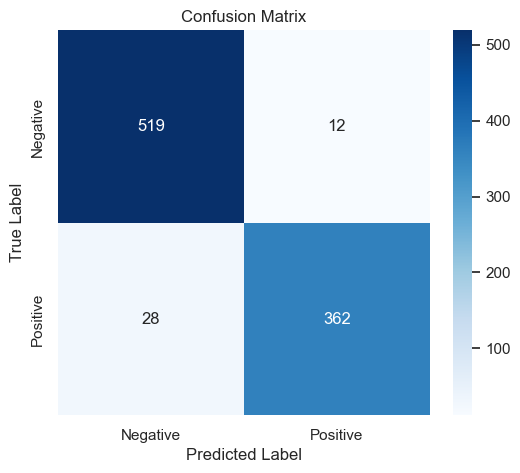

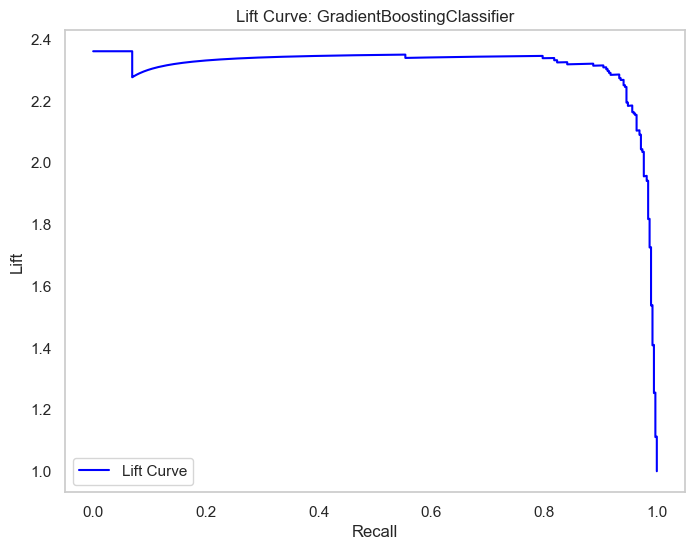

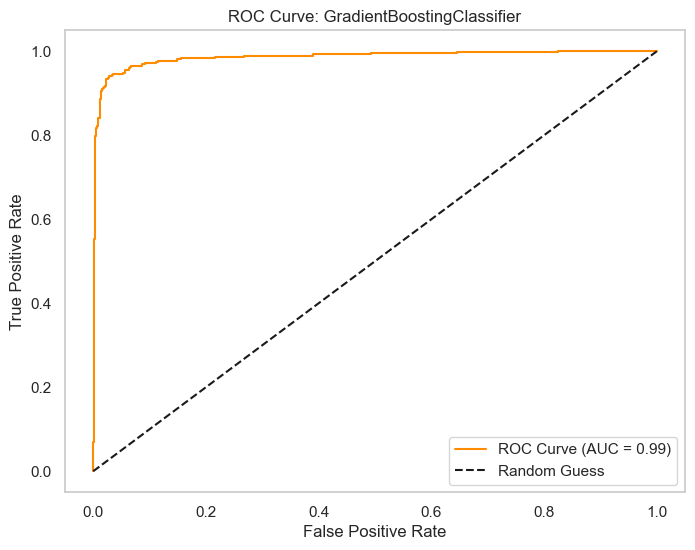

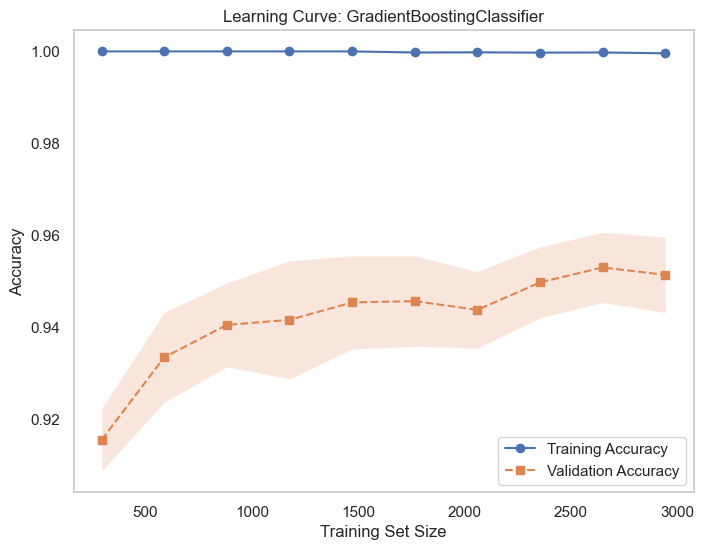

In [129]:
model = GradientBoostingClassifier(
    n_estimators=160,
    max_depth=7,
    learning_rate=0.192397,
    subsample=0.761491,
    min_samples_split=8,
    min_samples_leaf=2,
    random_state=42
)
# Evaluate the model with cost-sensitive analysis and validation curve
evaluate_model(
    model,
    X_train, y_train,
    X_test, y_test,
    cv=5,
    cost_fn=0,
    cost_fp=0
)

# MODEL 2: BASED ON COST SENSITIVITY

In [139]:
def cost_sensitive_score(y_true, y_pred, cost_fn=10, cost_fp=1):
    cm = confusion_matrix(y_true, y_pred)
    fn = cm[1, 0]
    fp = cm[0, 1]
    total_cost = (cost_fn * fn + cost_fp * fp)
    avg_cost = total_cost / len(y_true)
    return -avg_cost  # Negative so that higher score = lower cost

cost_score = make_scorer(cost_sensitive_score, greater_is_better=False, cost_fn=10, cost_fp=1)

### MODEL SELECTION USING NESTED CV

In [136]:
param_grids_2 = {
    'logistic': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']  
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'knn': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'mlp': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'solver': ['adam'],
        'learning_rate': ['constant', 'adaptive']
    },
    'gboost': {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
}

In [137]:
model_dict_2 = {
    'logistic': LogisticRegression(),
    'svm': SVC(probability=True),
    'knn': KNeighborsClassifier(),
    'random_forest': RandomForestClassifier(),
    'mlp': MLPClassifier(max_iter=500),
    'gboost': GradientBoostingClassifier()
}


 Running Nested CV for: logistic

→ Scoring Metric: Custom Scorer
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|   0.9589   | 0.0683  |
+------------+---------+
Best Hyperparameters:
   - clf__C: 0.01
   - clf__penalty: l1
   - clf__solver: liblinear

 Running Nested CV for: svm

→ Scoring Metric: Custom Scorer
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|   0.7570   | 0.0577  |
+------------+---------+
Best Hyperparameters:
   - clf__C: 0.1
   - clf__gamma: scale
   - clf__kernel: rbf

 Running Nested CV for: knn

→ Scoring Metric: Custom Scorer
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|   0.7251   | 0.0456  |
+------------+---------+
Best Hyperparameters:
   - clf__metric: manhattan
   - clf__n_neighbors: 9
   - clf__weights: uniform

 Running Nested CV for: random_forest

→ Scoring Metric: Custom Scorer
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|   0.4421 

TypeError: _BaseScorer.__call__() missing 2 required positional arguments: 'X' and 'y_true'

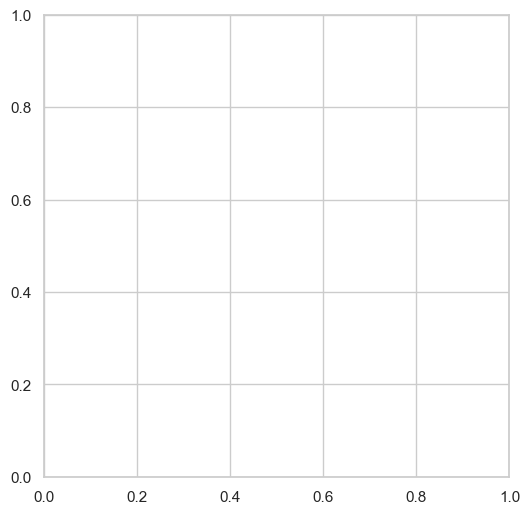

In [142]:
run_nested_cv(
    X, y,
    model_dict=model_dict_2,
    param_grids=param_grids_2,
    scoring_list=[cost_score],
    outer_splits=3,
    inner_splits=3
)

### HYPERPARAMTER TUNING USING OPTUNA

In [145]:
param_grid = {
    'C': lambda trial: trial.suggest_float('C', 1e-3, 100, log=True),  # inverse of regularization
    'penalty': lambda trial: trial.suggest_categorical('penalty', ['l2']),  # 'l1' only works with 'liblinear' or 'saga'
    'solver': lambda trial: trial.suggest_categorical('solver', ['lbfgs', 'saga']),
    'max_iter': lambda trial: trial.suggest_int('max_iter', 300, 500),
    'random_state': lambda trial: 42
}

best_logreg_params = tune_model_with_optuna(
    X_train, y_train.ravel(),
    model_class=LogisticRegression,
    param_grid=param_grid,
    scoring='accuracy',
    stratified=True,
    n_trials=50,
    direction='maximize'
)

[I 2025-03-28 20:00:45,615] A new study created in memory with name: no-name-ad440603-0cda-4a87-a90c-070db13ca944



 Starting Optuna Hyperparameter Tuning
 Model       : LogisticRegression
 Scoring     : accuracy
 CV Folds    : 5
 Direction   : maximize
 Trials      : 50



[I 2025-03-28 20:00:47,124] Trial 0 finished with value: 0.902445652173913 and parameters: {'C': 0.006115450907465742, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 380}. Best is trial 0 with value: 0.902445652173913.
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.


 Best Score Achieved:
   0.92663

 Best Hyperparameters Found:
╒══════════════════╤════════════════════╕
│ Hyperparameter   │ Value              │
╞══════════════════╪════════════════════╡
│ C                │ 13.011741761419996 │
├──────────────────┼────────────────────┤
│ penalty          │ l2                 │
├──────────────────┼────────────────────┤
│ solver           │ lbfgs              │
├──────────────────┼────────────────────┤
│ max_iter         │ 478                │
╘══════════════════╧════════════════════╛



Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       531
           1       0.92      0.88      0.90       390

    accuracy                           0.92       921
   macro avg       0.92      0.91      0.92       921
weighted avg       0.92      0.92      0.92       921


Test Set Evaluation:
Accuracy: 0.92
Precision: 0.92
Recall: 0.88
F1 Score: 0.90
ROC AUC: 0.9701047853590227
Average Misclassification Cost (FN=10, FP=1): 0.5299


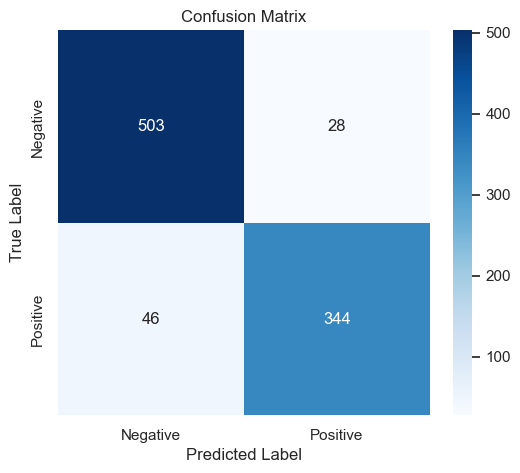

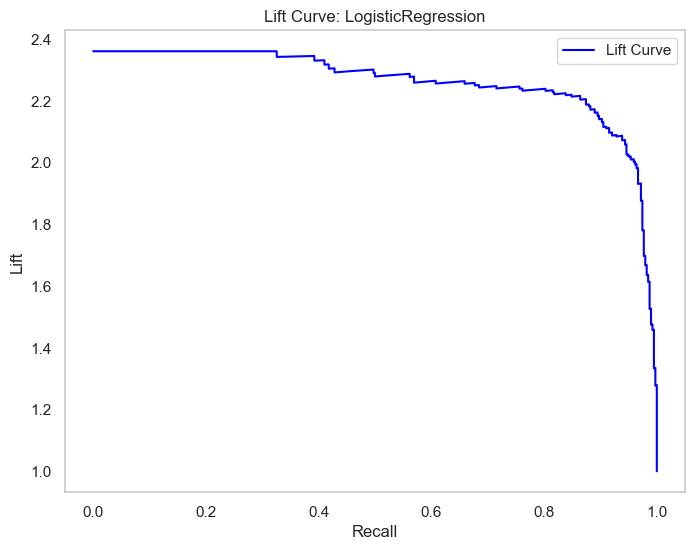

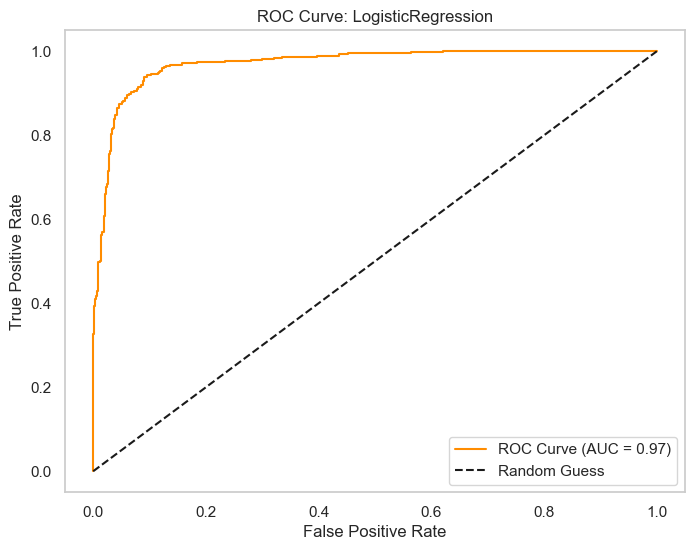

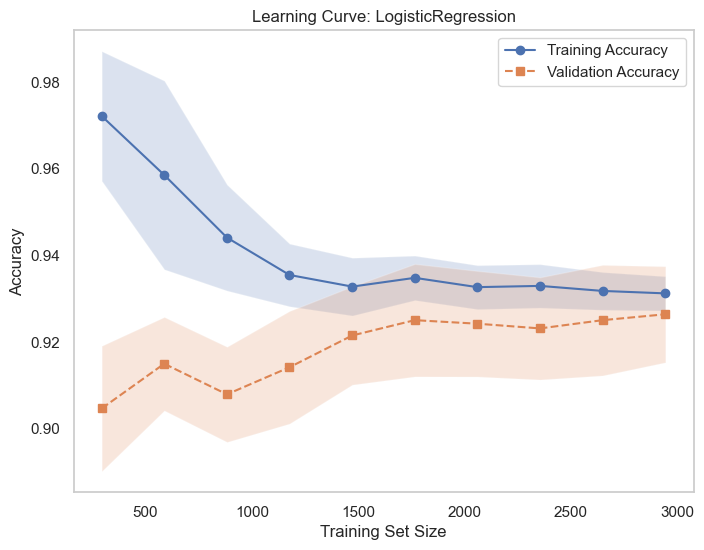

In [151]:
model = LogisticRegression(C = 13.011741761419996, 
                            penalty = 'l2',
                            solver = 'lbfgs',
                            random_state = 42,
                            max_iter = 478,
)   
# Evaluate the model with cost-sensitive analysis and validation curve
evaluate_model(
    model,
    X_train, y_train,
    X_test, y_test,
    cv=5,
    cost_fn=10,
    cost_fp=1
)